# Introduction

In this tutorial, we will learn to model online forums. 

In [1]:
devtools::load_all() # load the functions of the package

# Requirements:
#install.packages("igraph")
#install.packages("ggplot2")
#install.packages("tidyr")
#install.packages("dplyr")

Loading genthreads
Loading required package: iterators

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘data.table’

The following objects are masked from ‘package:dplyr’:

    between, first, last


Attaching package: ‘igraph’

The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine



## Vector representation of a tree

We will first learn how to represent the structure and dynamics of an online conversations in a very simple way. We will create its **parents vector**. The parents vector is a vector $\boldsymbol{\pi} = (\pi_1,...,\pi_2)$ where $\pi_t$ contains the parent of node $t$. Our package contains a function that plots the tree corresponding to a parents vector. For the above tree, we would have:

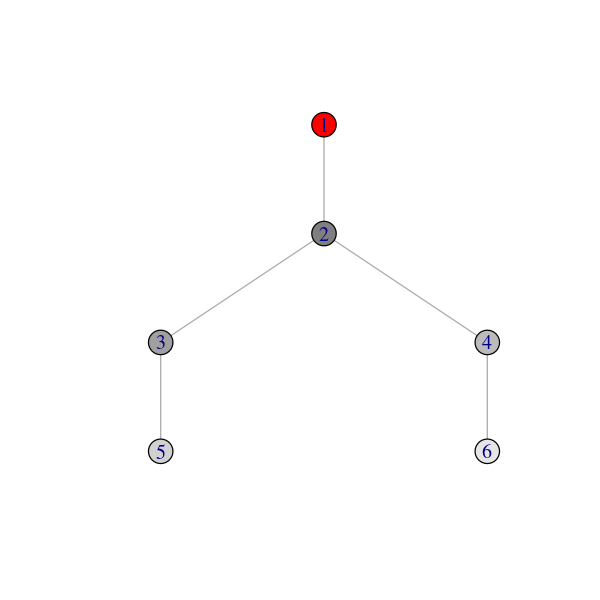

In [2]:
options(repr.plot.width=5, repr.plot.height=5)

# Vector representation
parents           <- c(1,2,2,3,4)

# Plot it as a tree
gtree             <- parents_to_tree(parents)
V(gtree)$color    <- gray.colors(vcount(gtree)) # all nodes are grey
V(gtree)[1]$color <- "red"                      # except the root
gtree.un          <- as.undirected(gtree)       
la                <- layout_as_tree(gtree.un, mode='out', root=1)
plot(gtree.un, layout = la, vertex.size=15)

## A real conversation

We will first load some conversations in Reddit to see what do they look like

Threads: 17030

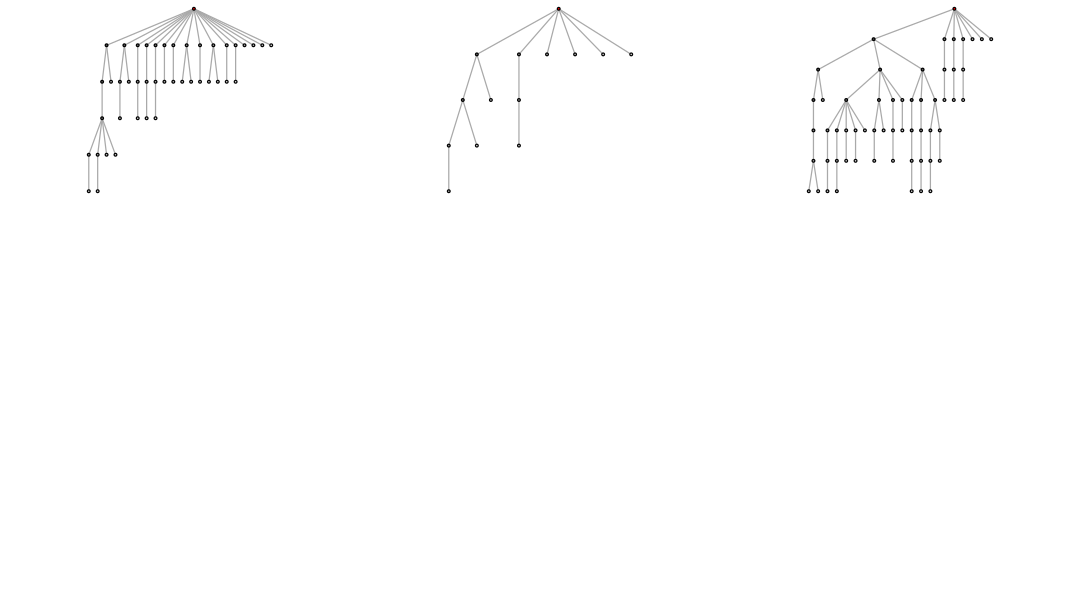

In [5]:
options(repr.plot.width=9, repr.plot.height=5)

# A python code to download reddit datasets and save them in a database 
# https://github.com/alumbreras/reddit_parser

data("df.posts.france")

df.thread <- df.posts %>%
  group_by(thread) %>% arrange(date) %>% filter(n()>10) %>%
  mutate(pi = as.integer(match(parent, unique(parent))-1)) %>% 
  ungroup %>%
  arrange(thread, date)

parents <- df.thread %>% filter(pi > 0) %>% group_by(thread) %>%  
  do(thread=.$pi) %>%  ungroup()  %>%
  lapply(function(x) {(x)})
parents <- parents[[1]]

cat('Threads:', length(parents))

# Plot some threads in tree and graph representations
par(mfrow = c(3,3))
for(i in 1:3){
  plot.tree(parents[[i]])
}

## Generating synthetic conversations with a growth model

Our conversation model is as follows:
$$
p(\pi_t) \propto \alpha d_{k,t} + \beta_{k} + \tau^{t-k+1}
$$

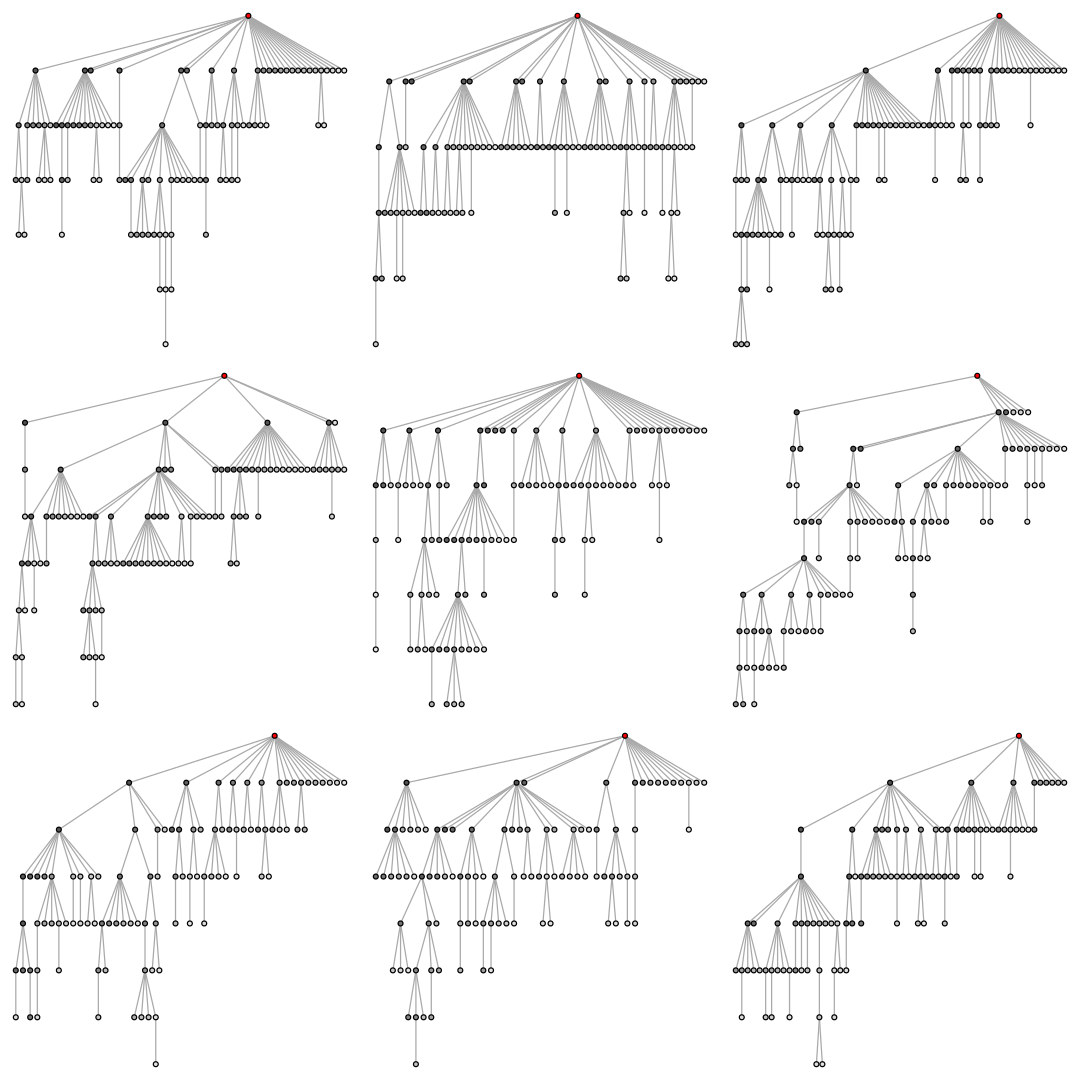

In [8]:
options(repr.plot.width=9, repr.plot.height=9)

alpha <- 0.5
beta <- 1
tau <- 0.5
ntrees <- 500
n = 100
parents <- replicate(ntrees,
                     gen.parentsvector.Gomez2013(n, alpha, beta, tau), 
                     simplify = FALSE)

par(mfrow = c(3,3))
for(i in 1:9){
  plot.tree(parents[[i]])
}

## Sanity check

Before fitting our model to real data, we will perform a sanity check so see whether we can recover the parameters of ou synthetic trees.

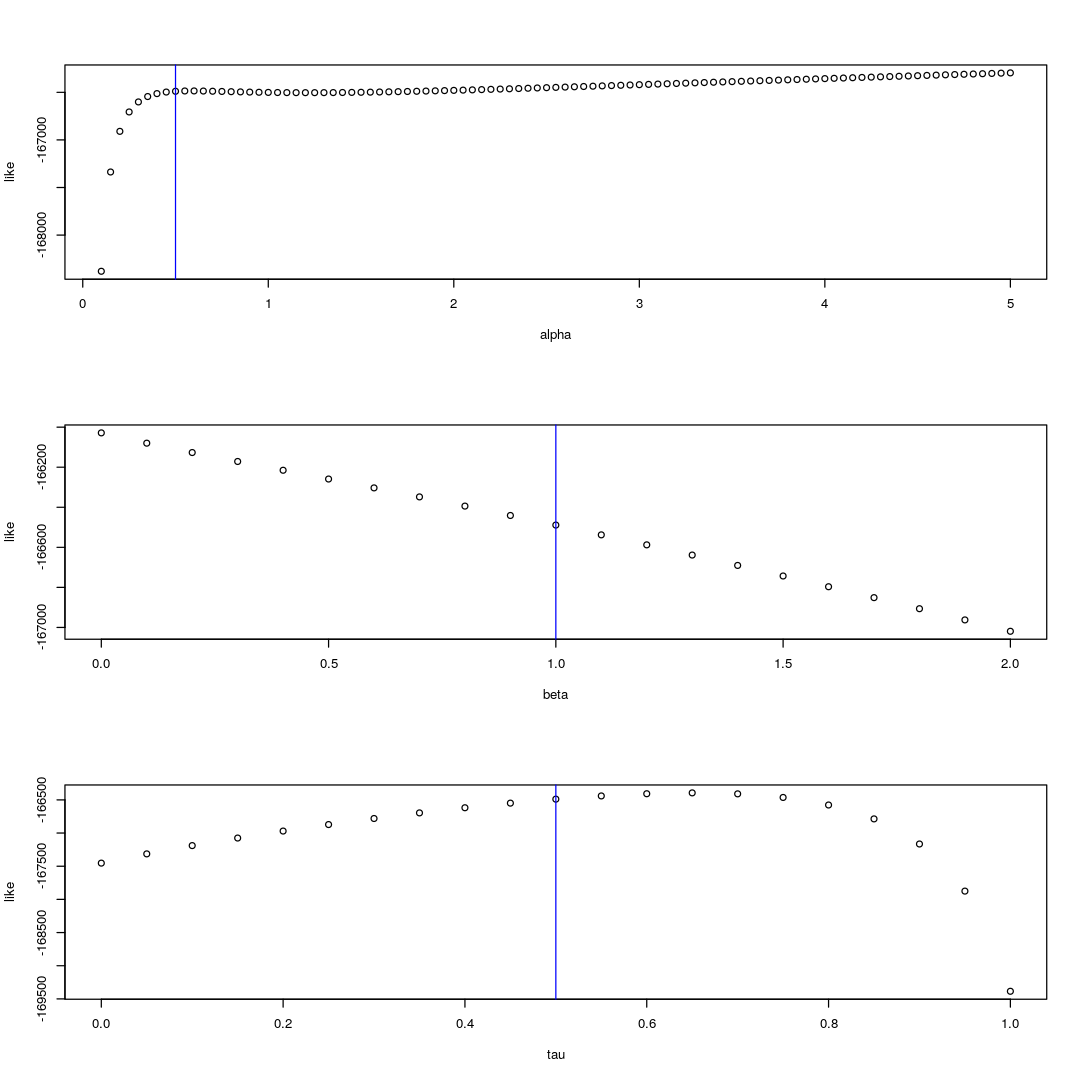

In [9]:
options(repr.plot.width=9, repr.plot.height=9)

par(mfrow = c(3,1))

df.trees <- all_parents_to_dataframe(parents)        

alpha_grid <- seq(0.1,5, by = 0.05)
like <- rep(NA, length(alpha_grid))
for(i in 1:length(alpha_grid)){
  like[i] <- likelihood_Gomez2013(df.trees, alpha_grid[i], beta, tau)
}
plot(alpha_grid, like, xlab = 'alpha')
abline(v=alpha, col = 'blue')

beta_grid <- seq(0,2, by = 0.1)
like <- rep(NA, length(beta_grid))
for(i in 1:length(beta_grid)){
  like[i] <- likelihood_Gomez2013(df.trees, alpha=alpha, beta_grid[i], tau)
}
plot(beta_grid, like, xlab = 'beta')
abline(v=beta, col = 'blue')

tau_grid <- seq(0,1, by = 0.05)
like <- rep(NA, length(tau_grid))
for(i in 1:length(tau_grid)){
  like[i] <- likelihood_Gomez2013(df.trees, alpha, beta, tau_grid[i])
}
plot(tau_grid, like, xlab = 'tau')
abline(v=tau, col = 'blue')


Attaching package: ‘tidyr’

The following object is masked from ‘package:igraph’:

    crossing

ERROR while rich displaying an object: Error in if ((w[1] * sm + w[2] * cm + w[3] * dm + w[4]) < best$score) break: valor ausente donde TRUE/FALSE es necesario

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     rpr <- mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     rpr <- mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
7. mime2repr[[mime]](obj)
8. repr_text.default(obj)
9. paste(capture.output(print(obj)), collapse = "\n")
10. capture.output(print(obj))
11. evalVis(exp

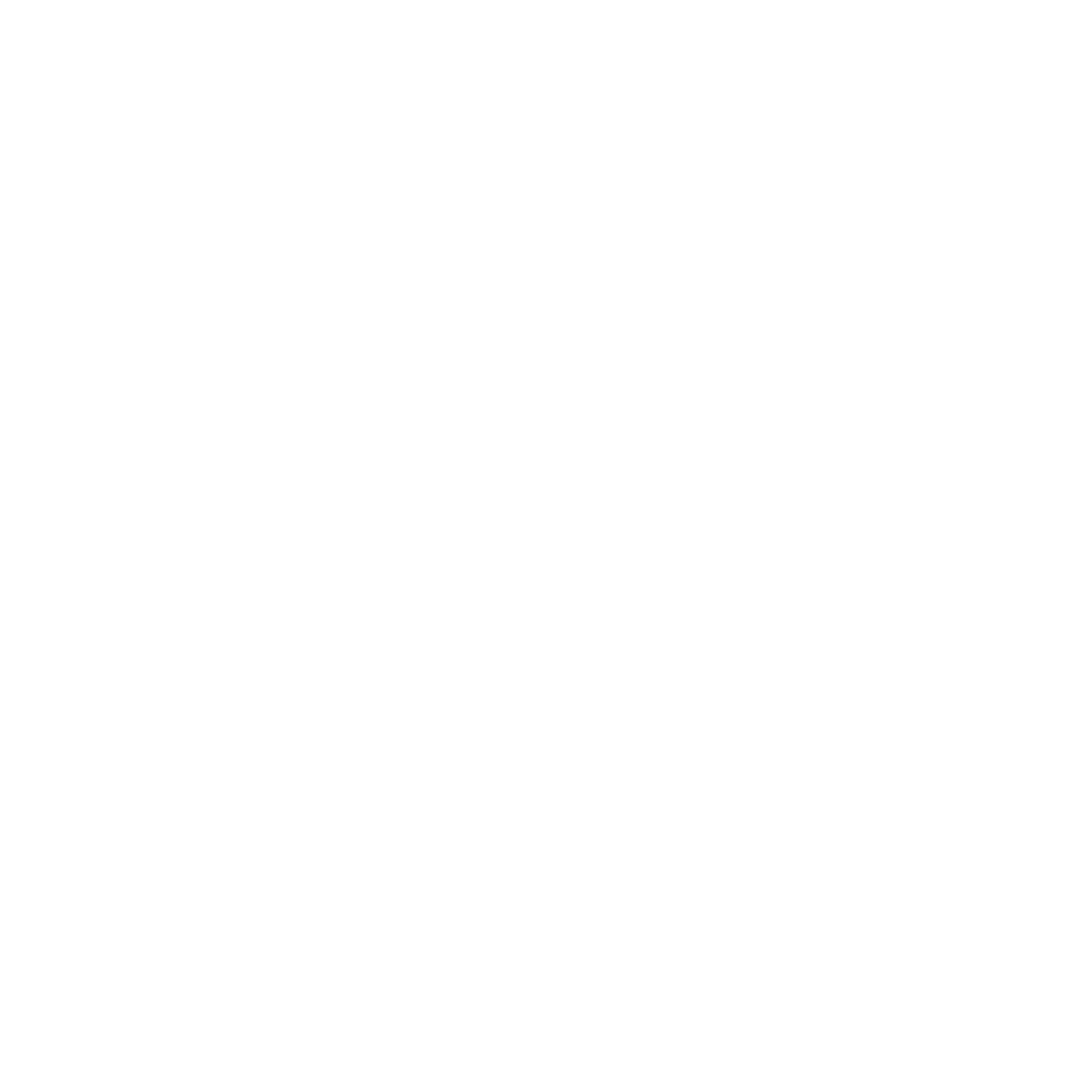

In [10]:
# Estimate paremeters with different initializations------------------------------------

alpha <- 0.5
beta <- 1
tau <- 0.5
ntrees <- 500
n = 100

df.trees <- all_parents_to_dataframe(parents)        
df.results <- data.frame()
for(ntrees in c(10, 1000)){
  # Generate trees
  parents <- replicate(ntrees, gen.parentsvector.Gomez2013(n, alpha, beta, tau), simplify = FALSE)
  df.trees <- all_parents_to_dataframe(parents)        
    
  # Estimate with different init parameters
  for(xp in 1:10){
    alpha_0 <- runif(1)
    beta_0  <- runif(1)*10
    tau_0   <- runif(1, max=0.99)
    res <- estimation_Gomez2013(df.trees = df.trees, params=list(alpha_0, beta_0, tau_0))
    res$ntrees <- ntrees
    df.results <- rbind(df.results, res)
  }
}

library(tidyr)
df.errors <- df.results 
df.errors$alpha <- df.errors$alpha - alpha
df.errors$beta <- df.errors$beta   - beta
df.errors$tau <- df.errors$tau     - tau
df.errors <- gather(df.errors, param, value, -likelihood, -ntrees)
df.errors$param <- factor(df.errors$param, levels = c("beta", "alpha", "tau"))
ggplot(df.errors, aes(x=param, y= value)) + 
  geom_point() + 
  facet_grid(.~ntrees) + theme_bw()

## Find model parameters that fit real conversations 

Now we the parameters to the real threads.

In [215]:
# Load again the real data
data("df.posts.france")

df.thread <- df.posts %>%
  group_by(thread) %>% arrange(date) %>% filter(n()>10) %>%
  mutate(pi = as.integer(match(parent, unique(parent))-1)) %>% 
  ungroup %>%
  arrange(thread, date)

parents <- df.thread %>% filter(pi > 0) %>% group_by(thread) %>%  
  do(thread=.$pi) %>%  ungroup()  %>%
  lapply(function(x) {(x)})
parents <- parents[[1]]

cat('Threads:', length(parents))

Threads: 17030

In [216]:
# Estimate parameters ----------------------------------------------------------

# Store in dataframe format. 
# Each line contains the post id, the chosen parent
# and the features of its parent (popularity, lag, root) at the 
# moment (t) of that choice.
df.trees <- all_parents_to_dataframe(parents)        

# Estimate alpha, beta, tau parameters
res <- estimation_Gomez2013(df.trees = df.trees, params=list(alpha=0.5, beta=0.6, tau=0.5))

In [221]:
res

$alpha
[1] 7.07196e+304

$beta
[1] 1e-04

$tau
[1] 1

$likelihood
[1] 8724311

## Compare structural properties

Finally, we check whether our model reproduces the structural properties of the real data.

In [217]:
# Generate threads with the estimated parameters
sizes <- sapply(parents, function(x) length(x))
parents_hat <- list()
for(i in 1:length(sizes)){
  parents_hat[[i]] <- gen.parentsvector.Gomez2013(sizes[i], res$alpha, res$beta, res$tau)
}


Processed  1000 / 17030
Processed  2000 / 17030
Processed  3000 / 17030
Processed  4000 / 17030
Processed  5000 / 17030
Processed  6000 / 17030
Processed  7000 / 17030
Processed  8000 / 17030
Processed  9000 / 17030
Processed  10000 / 17030
Processed  11000 / 17030
Processed  12000 / 17030
Processed  13000 / 17030
Processed  14000 / 17030
Processed  15000 / 17030
Processed  16000 / 17030
Processed  17000 / 17030
Processed  1000 / 17030
Processed  2000 / 17030
Processed  3000 / 17030
Processed  4000 / 17030
Processed  5000 / 17030
Processed  6000 / 17030
Processed  7000 / 17030
Processed  8000 / 17030
Processed  9000 / 17030
Processed  10000 / 17030
Processed  11000 / 17030
Processed  12000 / 17030
Processed  13000 / 17030
Processed  14000 / 17030
Processed  15000 / 17030
Processed  16000 / 17030
Processed  17000 / 17030

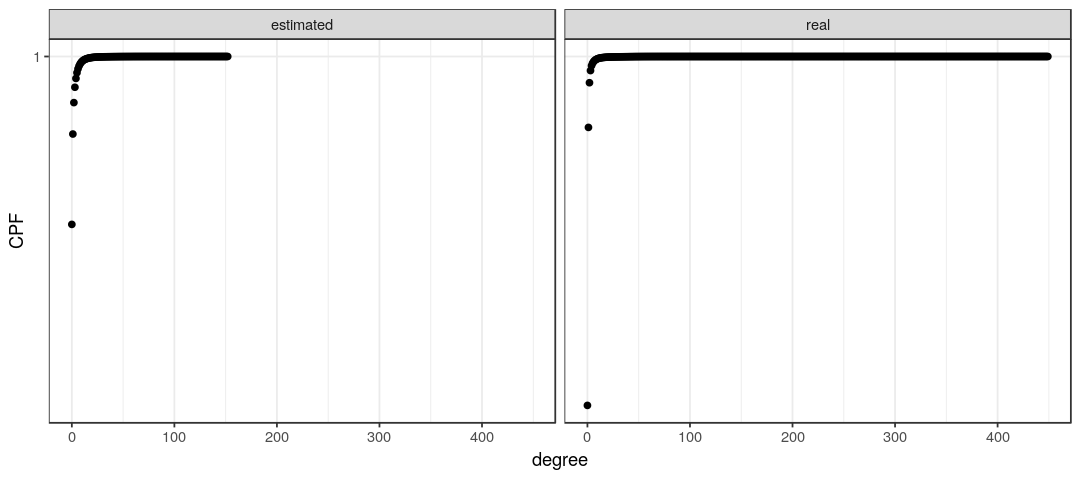


Processed  1000 / 17030
Processed  2000 / 17030
Processed  3000 / 17030
Processed  4000 / 17030
Processed  5000 / 17030
Processed  6000 / 17030
Processed  7000 / 17030
Processed  8000 / 17030
Processed  9000 / 17030
Processed  10000 / 17030
Processed  11000 / 17030
Processed  12000 / 17030
Processed  13000 / 17030
Processed  14000 / 17030
Processed  15000 / 17030
Processed  16000 / 17030
Processed  17000 / 17030
Processed  1000 / 17030
Processed  2000 / 17030
Processed  3000 / 17030
Processed  4000 / 17030
Processed  5000 / 17030
Processed  6000 / 17030
Processed  7000 / 17030
Processed  8000 / 17030
Processed  9000 / 17030
Processed  10000 / 17030
Processed  11000 / 17030
Processed  12000 / 17030
Processed  13000 / 17030
Processed  14000 / 17030
Processed  15000 / 17030
Processed  16000 / 17030
Processed  17000 / 17030

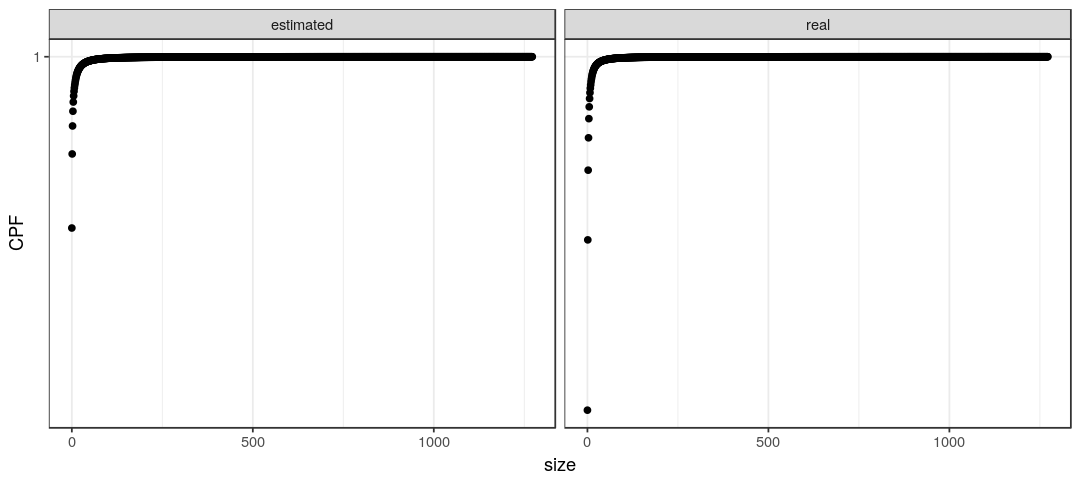

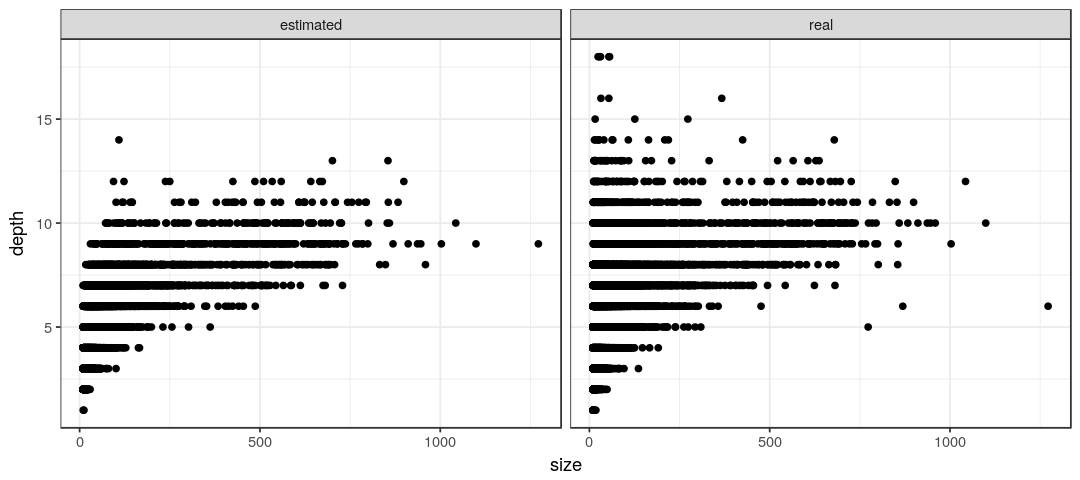

In [219]:
# Compare structural properties ------------------------------------------------

# Degree distribution
df.degrees     <- struct_degree_distribution(parents)
df.degrees_hat <- struct_degree_distribution(parents_hat)
df.degrees$cumprob     <- cumsum(df.degrees$frequency/sum(df.degrees$frequency))
df.degrees_hat$cumprob <- cumsum(
  df.degrees_hat$frequency/sum(df.degrees_hat$frequency)
)            

df.degrees$data     <- 'real'
df.degrees_hat$data <- 'estimated'
df.degrees <- bind_rows(df.degrees, df.degrees_hat)
ggplot(df.degrees, aes(x=degree, y = cumprob)) + 
  geom_point() +
  scale_y_log10() +
  facet_grid(.~data) +
  theme_bw() +
  ylab('CPF')

# Subtree size distribution
df.subtrees     <- struct_subtree_size_distribution(parents)
df.subtrees_hat <- struct_subtree_size_distribution(parents_hat)
df.subtrees$cumprob     <- cumsum(df.subtrees$frequency/sum(df.subtrees$frequency))
df.subtrees_hat$cumprob <- cumsum(
  df.subtrees_hat$frequency/sum(df.subtrees_hat$frequency)
)        

df.subtrees$data     <- 'real'
df.subtrees_hat$data <- 'estimated'
df.subtrees <- bind_rows(df.subtrees, df.subtrees_hat)
ggplot(df.subtrees, aes(x=size, y = cumprob)) + 
  geom_point() +
  scale_y_log10() +
  facet_grid(.~data) +
  theme_bw() +
  ylab('CPF')


# Size vs Depth
df.sizedepth     <- struct_size_depth(parents)
df.sizedepth_hat <- struct_size_depth(parents_hat)

df.sizedepth$data     <- 'real'
df.sizedepth_hat$data <- 'estimated'
df.sizedepth <- bind_rows(df.sizedepth, df.sizedepth_hat)
ggplot(df.sizedepth, aes(x=size, y = depth)) + 
  geom_point() +
  scale_y_log10() +
  facet_grid(.~data) +
  theme_bw() +
  xlab("size") + ylab('depth')